# Content Based Music Recommendation System

**Project Brief and goals**

As the number of people listening to music has been increasing over time, there are around 75% of people of the age group 25-34 who have a huge audio streaming engagement.
Spotify's discover weekly is quite accurate in its recommendations to its users and since personalisation of content adds a lot of value to user experience in today's world, we wanted to build a content based music recommendation system. This recommender system is built using Spotify's web API and we wanted to see how much of an effect audio features and artist information has on music recommendation. In the end we have also compared our model to that of Spotify's in-built recommendation API end point in order to evaluate our model.

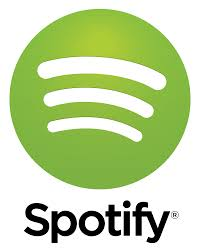







In [1]:
pip install spotipy

  Created wheel for spotipy: filename=spotipy-2.4.4-cp36-none-any.whl size=12336 sha256=fbab09ac89541b20828487f3d4b6f966e3da16e257fa4bf13c87651e526d2fd7
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
#Imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import spotipy.util as util
import pandas as pd
from collections import defaultdict
import tqdm
import json
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction import FeatureHasher
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import numpy as np
from sklearn.feature_extraction import FeatureHasher
from scipy.spatial import distance
import operator
import collections

## Spotify Web API OAuth

To access user specific information we need to request the user to authenticate. The user authentication process will provide us with a token which can then be used for all requests being made to the web api. While requesting access it is very important to declare the list of scopes we would need access to. In our project we only use the "user-read-recently-played" scope.
After running the below block of code please follow the steps provided in the output box to complete the authentication process.

In [0]:
cid ="31ee049db38047748e33466e912633ea" 
secret = "c7618c33b0b844a390700f5586470170"
scope  = "user-read-recently-played"
username = ''
token  = util.prompt_for_user_token\
        (
            username, 
            scope, 
            client_id       = cid, 
            client_secret   = secret,
            redirect_uri    = 'http://localhost:8880/callback' 
        )
#print(token)
sp = spotipy.Spotify(auth=token)

## Spotify Track Data Collection 

The first phase of our project involves collecting spotify track data. We first begin with collecting track ids of 10,000 songs for each year in the past 20 years by using spotify's search api endpoint. To the api we pass as input the year we are trying get tracks for. All this collected information is processed and stored in a dataframe.

In [0]:
def get_track_ids(years,limit):
  tracks_dict = defaultdict()
  for year in tqdm.tqdm_notebook(years):
    for i in range(0,10000,limit):
      track_results = sp.search(q='year:'+year, type='track', limit=limit,offset=i)
      for t in track_results['tracks']['items']:
        track_dict = {'artist_name':t['artists'][0]['name'],'artist_id':t['artists'][0]['id'],'track_name':t['name'],'popularity':t['popularity'], 'track_year':year}
        tracks_dict[t['id']] = track_dict
  return tracks_dict

In [5]:
years = [str(2000+i) for i in range(20)]
tracks_dict = get_track_ids(years,limit=50)
df_tracks = pd.DataFrame(tracks_dict).transpose()

We then use the track ids collected and query the api endpoint to collect the audio features of track. The track id is passed to the api endpoint as an input. Wee parse the recieved response and store it in a dataframe. Some of the features we collect are tempo, danceability, valence, liveness, mode and speechiness. 

In [0]:
def get_audio_features(track_ids):
  track_features_dict = defaultdict()
  for j in tqdm.tqdm_notebook(range(0,len(track_ids),50)):
    tracks = sp.audio_features(list(track_ids[j:j+50]))
    for i in range(len(tracks)):
      if tracks[i] != None:
        features_dict = { 'danceability':tracks[i]['danceability'],
                          'energy':tracks[i]['energy'],
                          'key':tracks[i]['key'],
                          'loudness':tracks[i]['loudness'], 
                          'mode':tracks[i]['mode'], 
                          'speechiness':tracks[i]['speechiness'], 
                          'acousticness':tracks[i]['acousticness'], 
                          'instrumentalness':tracks[i]['instrumentalness'], 
                          'liveness':tracks[i]['liveness'], 
                          'valence':tracks[i]['valence'], 
                          'tempo':tracks[i]['tempo'], 
                          'time_signature': tracks[i]['time_signature'] }
        track_features_dict[tracks[i]['id']] =  features_dict
  return track_features_dict 

In [7]:
track_features_dict =get_audio_features(df_tracks.index)
df_track_features = pd.DataFrame(track_features_dict).transpose()

retrying ...2secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...5secs
retrying ...1secs
retrying ...6secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...5secs
retrying ...1secs
retrying ...5secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...4secs
retrying ...1secs
retrying ...5secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...4secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...5secs
retrying ...1secs



We use the atrist ids acollected in the first step of the data collection process to get genre and popularity information about the artist by querying spotify's api endpoint. This endpoint takes the artist id as input.

In [0]:
def get_artist_info(artist_ids):
  artists_dict =defaultdict()
  #print(len(artist_ids))
  for j in tqdm.tqdm_notebook(range(0,len(artist_ids),50)):
    artists = sp.artists(list(artist_ids[j:j+50]))
    #print(artists['artists'])
    for i in range(len(artists['artists'])):
      if len(artists['artists'][i]['genres'])!=0: 
        art = {'artist_genre':artists['artists'][i]['genres'][0],'artist_popularity':artists['artists'][i]['popularity']}
        artists_dict[artists['artists'][i]['id']]=art
  return artists_dict

In [9]:
artists_dict= get_artist_info(df_tracks.artist_id.unique())
df_artists = pd.DataFrame(artists_dict).transpose()

retrying ...1secs
retrying ...1secs



After collecting tracks_ids, audio features and artist information we merge all these datasets together to create our final data set which will be used for training our model. We first merge the track_ids with the audio features and we then merge the artist information to this.

In [0]:
def merge_data(df_tracks,df_track_features,df_artists):
  final_tracks_df = df_tracks.merge(df_track_features, left_on=df_tracks.index, right_on=df_track_features.index)
  #print(final_tracks_df.columns)
  final_tracks_df = final_tracks_df.rename(columns={'key_0':'track_id'})
  final_tracks_df = final_tracks_df.merge(df_artists, left_on=final_tracks_df.artist_id, right_on=df_artists.index, how = 'left')
  final_tracks_df = final_tracks_df.rename(columns={'key_0':'artist_id'})
  #print(final_tracks_df.columns)
  final_tracks_df.dropna(subset=['artist_genre'], inplace = True)
  final_tracks_df.reset_index(drop = True, inplace=True )
  final_tracks_df.to_csv("data_set.csv")
  return final_tracks_df

In [0]:
final_tracks_df = merge_data(df_tracks,df_track_features,df_artists)

In [12]:
final_tracks_df

,artist_id,track_id,artist_name,artist_id,track_name,popularity,track_year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_genre,artist_popularity
0,6XyY86QOPPrYVGvF9ch6wz,60a0Rd6pjrkxjPbaKzXjfq,Linkin Park,6XyY86QOPPrYVGvF9ch6wz,In the End,84,2000,0.556,0.864,3.0,-5.870,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,4.0,alternative metal,88
1,2RTUTCvo6onsAnheUk3aL9,6ZOBP3NvffbU4SZcrnt1k6,3 Doors Down,2RTUTCvo6onsAnheUk3aL9,Kryptonite,79,2000,0.545,0.865,11.0,-5.708,0.0,0.0286,0.00664,0.000011,0.1680,0.543,99.010,4.0,alternative metal,74
2,1l7ZsJRRS8wlW3WfJfPfNS,32h59T8q2SonUPJ006lyXt,Christina Aguilera,1l7ZsJRRS8wlW3WfJfPfNS,This Christmas,77,2000,0.575,0.744,1.0,-5.466,1.0,0.0603,0.06870,0.000000,0.0723,0.701,183.790,4.0,dance pop,83
3,1l7ZsJRRS8wlW3WfJfPfNS,0iV9yfj1knFNOSEiuTHZwl,Christina Aguilera,1l7ZsJRRS8wlW3WfJfPfNS,Have Yourself a Merry Little Christmas,77,2000,0.244,0.274,8.0,-10.433,1.0,0.0400,0.87100,0.000012,0.0897,0.164,68.534,4.0,dance pop,83
4,4gzpq5DPGxSnKTe4SA8HAU,3AJwUDP919kvQ9QcozQPxg,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,Yellow,83,2000,0.429,0.661,11.0,-7.227,1.0,0.0281,0.00239,0.000130,0.2340,0.285,173.365,4.0,permanent wave,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190465,3ycxRkcZ67ALN3GQJ57Vig,0VEJDwMO26qNitqyDb47I0,Masego,3ycxRkcZ67ALN3GQJ57Vig,Big Girls,59,2019,0.821,0.457,6.0,-12.116,1.0,0.1950,0.14700,0.118000,0.1220,0.252,113.923,4.0,alternative r&b,73
190466,3XlIhgydjvC4EniPFZT20j,1TU7prccGLiAY0y59oa1at,Trisha Yearwood,3XlIhgydjvC4EniPFZT20j,Every Girl in This Town,53,2019,0.616,0.681,7.0,-7.265,1.0,0.0304,0.05720,0.000000,0.0899,0.353,111.942,4.0,contemporary country,63
190467,1IJe80moz409PtxW4llPFw,5zEsGtsZzKhVWSAerDfoSD,Sleepy Fish,1IJe80moz409PtxW4llPFw,Forgot It Was Monday,57,2019,0.749,0.389,11.0,-12.911,1.0,0.0647,0.42800,0.943000,0.0874,0.152,142.092,4.0,chillhop,65
190468,5usbqiU7sjvszjWecANDL6,0UPFerZ0voLFW8uIogZhUg,Boogie,5usbqiU7sjvszjWecANDL6,Skydive II (feat. 6LACK),55,2019,0.744,0.484,4.0,-6.824,1.0,0.1440,0.58100,0.000014,0.1030,0.354,124.102,4.0,hip hop,64


In [0]:
# final_tracks_df = pd.read_csv("data_set.csv")
# final_tracks_df.dropna(subset=['artist_genre'], inplace = True)
# final_tracks_df.reset_index(drop = True, inplace=True )


## User Recently Played Data Collection

To make recommedations to user we need first need to collect the users track history. To do this we collect the users last 20 songs played on spotify. For this we used the requests library to get the track ids of the last 10 songs . We then parsed this information stored it as a dataframe. 

In [0]:
def get_user_tracks(url):
  tracks_dict = defaultdict()
  query={'limit':20}
  headers = {'Authorization': "Bearer {}".format(token)}
  r = requests.get(url, headers=headers,params=query)
  parsed = json.loads(r.text)
  #print(parsed)
  for t in tqdm.tqdm_notebook(parsed['items']):
    track_dict = {'artist_name':t['track']['artists'][0]['name'],'artist_id':t['track']['artists'][0]['id'],'track_name':t['track']['name'],'popularity':t['track']['popularity']}
    tracks_dict[t['track']['id']] = track_dict
  return tracks_dict

In [14]:
url= "https://api.spotify.com/v1/me/player/recently-played"
user_tracks_dict = get_user_tracks(url)
df_user_tracks = pd.DataFrame(user_tracks_dict).transpose()

Similar to the collection process above we use the functions defined earlier to collect the audio features and artist information of the user's last 20 tracks.

In [15]:
track_user_features_dict =get_audio_features(df_user_tracks.index)
df_user_track_features = pd.DataFrame(track_user_features_dict).transpose()

In [16]:
artists_user_dict = get_artist_info(df_user_tracks.artist_id.unique())
df_artists_user = pd.DataFrame(artists_user_dict).transpose()

We then use the merge funstion to combine above collected dataframes.

In [0]:
final_user_tracks_df = merge_data(df_user_tracks,df_user_track_features,df_artists_user)

In [18]:
final_user_tracks_df

,artist_id,track_id,artist_name,artist_id,track_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_genre,artist_popularity
0,5Pwc4xIPtQLFEnJriah9YJ,6hLkeOMrhZ2CMLBp2of576,OneRepublic,5Pwc4xIPtQLFEnJriah9YJ,Wanted,78,0.668,0.534,1.0,-6.586,1.0,0.0677,0.16400,0.000000,0.1000,0.711,145.816,4.0,dance pop,86
1,5X4LWwbUFNzPkEas04uU82,7CTzuqi7g4vW8BXcEacvdB,DVBBS,5X4LWwbUFNzPkEas04uU82,GOMF,65,0.749,0.659,9.0,-6.746,0.0,0.0343,0.00198,0.000755,0.1810,0.407,114.964,4.0,big room,69
2,5nki7yRhxgM509M5ADlN1p,50JXRlI4j4Fkh6PT9vUYsn,Oliver Heldens,5nki7yRhxgM509M5ADlN1p,Cucumba,59,0.777,0.935,11.0,-4.062,1.0,0.0501,0.28700,0.947000,0.1120,0.337,125.960,4.0,big room,79
3,7n2wHs1TKAczGzO7Dd2rGr,1IXGILkPm0tOCNeq00kCPa,Shawn Mendes,7n2wHs1TKAczGzO7Dd2rGr,If I Can't Have You - Gryffin Remix,70,0.642,0.818,2.0,-4.552,1.0,0.0320,0.05670,0.000000,0.0919,0.590,124.957,4.0,canadian pop,94
4,500YRyClzP6Z7HtWd1BIje,0X4jl7YzCThdCgYT9Enj9i,Northeast Party House,500YRyClzP6Z7HtWd1BIje,Magnify,57,0.669,0.771,0.0,-4.736,0.0,0.0371,0.00233,0.000889,0.3760,0.373,125.956,3.0,australian hip hop,55
5,5jAMCwdNHWr7JThxtMuEyy,7FjZU7XFs7P9jHI9Z0yRhK,NOTD,5jAMCwdNHWr7JThxtMuEyy,So Close,81,0.700,0.872,10.0,-5.896,1.0,0.0666,0.12100,0.000007,0.1030,0.761,125.030,4.0,dance pop,76
6,1HBjj22wzbscIZ9sEb5dyf,4NSW0Km5ZG60L8FthUebPJ,Jonas Blue,1HBjj22wzbscIZ9sEb5dyf,What I Like About You (feat. Theresa Rex),83,0.460,0.800,1.0,-3.584,1.0,0.0500,0.28900,0.000006,0.1210,0.553,102.460,4.0,dance pop,85
7,6USv9qhCn6zfxlBQIYJ9qs,1tNJrcVe6gwLEiZCtprs1u,Dominic Fike,6USv9qhCn6zfxlBQIYJ9qs,3 Nights,87,0.815,0.518,7.0,-6.594,0.0,0.0897,0.22300,0.000000,0.1040,0.877,151.891,4.0,alternative pop rock,78
8,2ZRQcIgzPCVaT9XKhXZIzh,2zh01m4PiHaZz4BAm0NRxs,Gryffin,2ZRQcIgzPCVaT9XKhXZIzh,Tie Me Down (with Elley Duhé),64,0.608,0.845,6.0,-2.292,1.0,0.0597,0.13600,0.000000,0.1110,0.322,98.976,4.0,dance pop,81
9,7w1eTNePApzDk8XtgykCPS,3DKKhdNzpFbRlo0XaaZBLk,Malaa,7w1eTNePApzDk8XtgykCPS,Revolt,58,0.737,0.905,4.0,-1.965,1.0,0.0785,0.00873,0.237000,0.2760,0.337,104.980,4.0,bass house,62


## Feature Hashing for Categorical Variables

Since we have around 32000 unique artist names and various artist genres one hot encoding isn't the optimal way of handling these categorical variables. We therefore use FeatureHasher from Pythons Sklearn to encode them. n_features (a parameter in FeatureHasher) is the the number of output features we want a particular variable to be represented as and we choose 100 for the same. 

In [0]:
#Feature hashing for categorical features
def feature_hashing(data,N):
  data['artist_name']=data['artist_name'].fillna("")
  data['artist_genre']= data['artist_genre'].fillna("")
  fh = FeatureHasher(n_features=N, input_type='string')
  hashed_features1 = fh.fit_transform(data['artist_name'])
  hashed_features1 = hashed_features1.toarray()
  hashed_features2 = fh.fit_transform(data['artist_genre'])
  hashed_features2 = hashed_features2.toarray()
  df=data.drop(labels=['artist_name','artist_genre'],axis=1)
  df=pd.concat((df,pd.DataFrame(hashed_features1), pd.DataFrame(hashed_features2)),axis=1)
  return df

final_tracks_df has the final data of previous years' songs.In this step we drop the irrelevant columns from that data frame, performing feature hashing on categorical variables and then convert the songs_data dataframe into an ndarray

In [20]:
songs_data = final_tracks_df
songs_data_temp = songs_data.drop(['artist_id','artist_id','track_id','track_name','track_year'], axis = 1)
songs_data_temp1 = feature_hashing(songs_data_temp,100)
song_data_array = songs_data_temp1.to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Clustering

To cluster the song data, we use elbow plot to detrmine the best value of the number of clusters, we performed k-means clustering on the song data with k values ranging from 1 to 30 and plot them against their errors. From the elbow plot we can see that the best k value is 7 post which the error does not decrease significanlty. Therefore the number of clusters we use for clustering is 7.

In [0]:
#Elbow plot for determining the best k for clustering 
def elbow_plot(song_data_array):
  errors = []
  K = range(1,30)
  for k in tqdm.tqdm_notebook(K):
      kmeanModel = KMeans(n_clusters=k).fit(song_data_array)
      kmeanModel.fit(song_data_array)
      errors.append(sum(np.min(cdist(song_data_array, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / song_data_array.shape[0])

  # Plot the elbow
  plt.plot(K, errors, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Error')
  plt.title('The Elbow Method showing the optimal k')

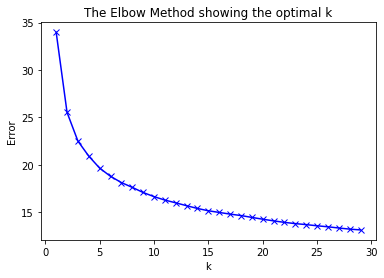

In [22]:
elbow_plot(song_data_array)

In this block we use PCA to reduce dimensionality of our song data for clustering. Choosing two as the number of principal component axis, we  see that the variance explained by them is 68% and 18% which does not improve significantly as we increase the number of axes. Therefore we reduce the dimensionality to two features. 

In [0]:
#Dimensionality reduction using PCA
def func_pca(data):
  pca = PCA(n_components=2)
  data_transformed = pca.fit_transform(data)
  print(pca.explained_variance_ratio_)
  return data_transformed

In [24]:
song_data_transformed = func_pca(song_data_array)

[0.68831996 0.18617734]


Using the number of clusters as 7, we cluster our transformed song data using K means clustering

In [0]:
#K means Clustering
def kmeans(song_data_transformed,N):
  kmeans = KMeans(n_clusters=N, n_init=10, random_state=0)
  kmeans.fit(song_data_transformed)
  kmeans_cluster_assignments = kmeans.predict(song_data_transformed)
  songs_data['Clusters'] = kmeans_cluster_assignments  
  return kmeans,songs_data,kmeans_cluster_assignments

In [0]:
kmeans,songs_data,kmeans_cluster_assignments=kmeans(song_data_transformed,N=7)

Plotting these clusters using scatter plot

(-124.02251391520281,
 134.31132276515433,
 -65.94587803924033,
 67.02321428460688)

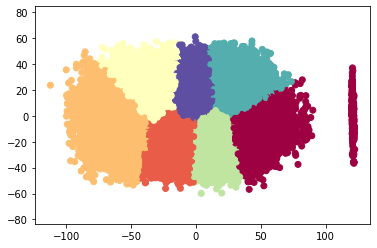

In [27]:
plt.scatter(song_data_transformed[:, 0], song_data_transformed[:, 1], c=kmeans_cluster_assignments, cmap='Spectral')
plt.axis('equal')

Another technique that we are using for clustering is Gaussian Mixture Models. We want to ensure that our clusteres are consistent and therefore we juse GMM to cluster the transformed song data into 7 clusters

In [0]:
#Clustering using Gaussian Mixture Model on the transformed song data(only 2 dimensions)
def gmm(song_data_transformed,N):
  gmm = GaussianMixture(n_components=7, n_init=10, random_state=0)
  gmm.fit(song_data_transformed)
  gmm_cluster_assignments = gmm.predict(song_data_transformed)
  plt.scatter(song_data_transformed[:, 0], song_data_transformed[:, 1], c=gmm_cluster_assignments, cmap='Spectral')
  plt.axis('equal')

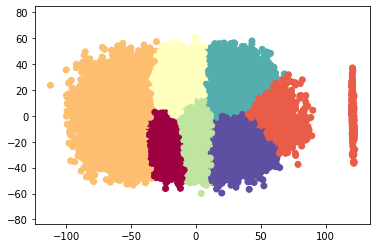

In [29]:
gmm(song_data_transformed,N=7)

From the above plots we can see that both k-means and GMM give us almost same clusters. We are going ahead with k-means for the process further

In [30]:
#Clustering using k means on user song data 
user_songs_data = final_user_tracks_df
user_songs_data_temp = user_songs_data.drop(['artist_id','artist_id','track_id' ,'track_name'], axis = 1)
user_songs_data_temp = feature_hashing(user_songs_data_temp,100)
user_song_array = user_songs_data_temp.to_numpy()
user_song_data_transformed = func_pca(user_song_array)
kmeans_cluster_assignments = kmeans.predict(user_song_data_transformed)
user_songs_data['Clusters'] = kmeans_cluster_assignments

[0.70170766 0.18945847]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Recommendations

### Our Recommendation

After building our model we now need to use it to provide track recommendations to the user based on his listening history.
Our recommendation process involves using our model to predict the cluster that each user track belongs to. We then collect all the tracks in that particular cluster and evaluate the similarity between the user track and the tracks in the cluster. 
To evaluate similarity, we calculate the euclidean distance between each track pair. 
The recommended track is the track that is seperated by the least amount of distance from the user track.

In [0]:
from sklearn.metrics.pairwise import euclidean_distances
def euclidean_distance(songs_data,user_songs_data):
  
  result=collections.defaultdict(list)
  songs_data_filter=feature_hashing(songs_data,100)
  user_songs_data_filter=user_songs_data.drop(['artist_id','track_id','artist_id','track_name'],axis=1)
  user_songs_data_filter=feature_hashing(user_songs_data_filter,100)
  user_songs_data_np = user_songs_data_filter.to_numpy()

  for i in tqdm.tqdm_notebook(range(len(user_songs_data))):
    cluster=user_songs_data['Clusters'][i]
    songs_data_cluster=songs_data_filter[songs_data_filter['Clusters']==cluster]
    songs_data_cluster.reset_index(drop=True,inplace=True)
    songs_data_cluster_filter=songs_data_cluster.drop(['artist_id','track_id','artist_id','track_name','track_year'],axis=1)
    X = songs_data_cluster_filter.to_numpy()
    song=user_songs_data_np[i].reshape(1,len(user_songs_data_np[i]))
    distance = euclidean_distances(X, song)
    valid_idx = np.where(distance > 0)[0]
    min_distance = distance[valid_idx].argmin()
    result[songs_data_cluster['track_id'][min_distance]]=user_songs_data['track_id'][i]
  return result

In [32]:
smm_recommender_system = euclidean_distance(songs_data,user_songs_data)
smm_recommender_system

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


defaultdict(list,
            {'01XFgRZfZI7oBagNf1Loml': '3DKKhdNzpFbRlo0XaaZBLk',
             '04jqhpf3oV06HtlmthfcZZ': '7FjZU7XFs7P9jHI9Z0yRhK',
             '0BvhrGwe5MtFFf9gMIeWbp': '6MSuMFyOdoJMAEgvnhqbRu',
             '0Y08zhvCal5BZZNS0RqBFN': '6hLkeOMrhZ2CMLBp2of576',
             '0ZiGRciYMWrDvCPNM0T21o': '4NSW0Km5ZG60L8FthUebPJ',
             '1Fx9aiORwv0cx5mFEBasHo': '0X4jl7YzCThdCgYT9Enj9i',
             '1ZpyIjwjGyW6Pt5NrQ0f1w': '50JXRlI4j4Fkh6PT9vUYsn',
             '1veoLuuMcaSn6rPACuG52I': '0DiDStADDVh3SvAsoJAFMk',
             '1xIHfkc6IJB76YjB9EDcez': '7CTzuqi7g4vW8BXcEacvdB',
             '24gxdUxufJ5eSamdYcPAKH': '4pnIUqhf1AQMFrJPd4BbrT',
             '30y8W512Sf3RbhVDHF38vY': '1tNJrcVe6gwLEiZCtprs1u',
             '42DsNAYP3JAqzhjUJ3ohPm': '57Fdoam9PVBqfkIRvUpUTQ',
             '4lzTyLYXb3ED01TSLCJ1Hz': '5YN0zHycJ0Yxz31A5QsVov',
             '5njFCHCaUvHQSqNFluZ36A': '0bfWT3AgM7ZTuqesJvRP6H',
             '5tZWtGT65sMrDVPB5H444n': '5tZWtGT65sMrDVPB5H444n',
       

In [33]:
smm_tracks=smm_recommender_system.keys()
smm_tracks_features = songs_data[songs_data['track_id'].isin(smm_tracks)]
smm_tracks_features['Original_Track'] = smm_tracks_features['track_id'].map(smm_recommender_system)
smm_tracks_features.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
smm_tracks_features

,artist_id,track_id,artist_name,artist_id,track_name,popularity,track_year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_genre,artist_popularity,Clusters,Original_Track
0,6BrWnoM0y0Viv3DVEcT8GE,5njFCHCaUvHQSqNFluZ36A,Glup!,6BrWnoM0y0Viv3DVEcT8GE,Complice Eterno,54,2001,0.646,0.620,2.0,-5.859,1.0,0.0282,0.530000,0.000000,0.3490,0.740,93.968,4.0,chilean indie,55,0,0bfWT3AgM7ZTuqesJvRP6H
1,2r09Inibex3C4ZNTUVSG3m,24gxdUxufJ5eSamdYcPAKH,Keith Sweat,2r09Inibex3C4ZNTUVSG3m,I Want Her,53,2004,0.757,0.496,11.0,-8.031,0.0,0.0467,0.002190,0.000093,0.0395,0.862,107.963,4.0,dance pop,62,4,4pnIUqhf1AQMFrJPd4BbrT
2,7xGGqA85UIWX1GoTVM4itC,4lzTyLYXb3ED01TSLCJ1Hz,The Staple Singers,7xGGqA85UIWX1GoTVM4itC,Respect Yourself,54,2007,0.828,0.669,6.0,-8.637,0.0,0.0254,0.160000,0.003330,0.0756,0.926,109.964,4.0,chicago soul,60,4,5YN0zHycJ0Yxz31A5QsVov
3,3EBRANWwnViQuBrImN61Z1,1Fx9aiORwv0cx5mFEBasHo,Pixie Lott,3EBRANWwnViQuBrImN61Z1,All About Tonight,58,2011,0.637,0.804,2.0,-6.141,1.0,0.0448,0.207000,0.000000,0.1150,0.732,129.261,3.0,australian pop,56,6,0X4jl7YzCThdCgYT9Enj9i
4,25fqWEebq6PoiGQIHIrdtv,01XFgRZfZI7oBagNf1Loml,Baauer,25fqWEebq6PoiGQIHIrdtv,Harlem Shake,60,2013,0.452,0.794,0.0,-5.151,1.0,0.0483,0.011100,0.001820,0.4160,0.282,137.825,4.0,bass trap,63,3,3DKKhdNzpFbRlo0XaaZBLk
5,7HIN94LvSDgxN5RoOLi3E5,7qBNJBQJJjQjYFZlP3IPhK,Dimmi,7HIN94LvSDgxN5RoOLi3E5,Dizzy,56,2014,0.811,0.510,9.0,-6.474,0.0,0.0424,0.019700,0.072000,0.0540,0.641,125.035,4.0,deep tropical house,52,1,5Uw7Dut2lZfexn3Y09swpf
6,1vCWHaC5f2uS3yhpwWbIA6,7kbTZWt7DnzIzbkyzFE1PW,Avicii,1vCWHaC5f2uS3yhpwWbIA6,For A Better Day,67,2015,0.639,0.843,5.0,-3.393,1.0,0.0334,0.038600,0.082900,0.1080,0.317,135.002,4.0,big room,88,3,2zh01m4PiHaZz4BAm0NRxs
7,4PbnqEBfculpCqF2C7hLO4,30y8W512Sf3RbhVDHF38vY,Tom's Music Box,4PbnqEBfculpCqF2C7hLO4,Lullaby and Good Night,56,2015,0.917,0.185,2.0,-10.079,1.0,0.1200,0.596000,0.859000,0.1290,0.775,94.029,3.0,children's music,54,0,1tNJrcVe6gwLEiZCtprs1u
8,6d1HqiWNEKV9zFqQM9WeYo,04jqhpf3oV06HtlmthfcZZ,Romare,6d1HqiWNEKV9zFqQM9WeYo,All Night,61,2016,0.885,0.485,10.0,-9.299,1.0,0.0872,0.086800,0.790000,0.0883,0.670,106.394,4.0,deep house,58,4,7FjZU7XFs7P9jHI9Z0yRhK
9,2rj2ySmbSsmrzVGtufnXAZ,1veoLuuMcaSn6rPACuG52I,Aeble,2rj2ySmbSsmrzVGtufnXAZ,Better By Your Side,60,2016,0.637,0.790,1.0,-7.785,0.0,0.0424,0.005570,0.209000,0.0682,0.584,121.997,4.0,indie soul,47,1,0DiDStADDVh3SvAsoJAFMk


### Spotify Recommendation

In order to evaluate the performance of our model, we need some metric to determine the relevance of our recommendation. To this end, we use Spotify's recommendation API endpoint. The API takes user track ids as input and provides us one recommendation per user track id as a response.

In [0]:
def recommendation_spotify(track_ids):
  tracks_rec={}
  for i in range(len(track_ids)):
    params={'seed_tracks':track_ids[i],'limit':1}
    headers1 = {'Authorization': "Bearer {}".format(token)}
    request = requests.get("https://api.spotify.com/v1/recommendations", headers=headers1,params=params)
    json_text = json.loads(request.text)
    for val in json_text['tracks']:
      tracks_rec[val['id']]={'original_track':track_ids[i]}
  return tracks_rec  

We then use the track ids collected from Spotify's recommendation engine to get their audio features and artist information. Most of the functions defined above are used for this purpose. 

In [0]:
def get_popularity_artist_id(track_ids):
  result = sp.tracks(track_ids)
  popularity = []
  artist_id = []
  artist_name = []
  for track in result['tracks']:
    popularity.append(track['popularity'])
    artist_id.append(track['artists'][0]['id'])
    artist_name.append(track['artists'][0]['name'])
  return popularity,artist_id,artist_name

After collecting the information above, we drop the irrelevant columns, perform feature hashing and process the data into a form that can be used for calculating euclidean distance.

In [39]:
spotify_tracks_rec_dict=recommendation_spotify(df_user_tracks.index)
df_spotify_tracks_rec_ids = pd.DataFrame(spotify_tracks_rec_dict).transpose()
spotify_tracks_rec_features=get_audio_features(df_spotify_tracks_rec_ids.index)
df_spotify_tracks_rec_features = pd.DataFrame(spotify_tracks_rec_features).transpose()
popularity,artist_id,artist_name = get_popularity_artist_id(df_spotify_tracks_rec_ids.index)
df_spotify_tracks_rec_features['popularity']= popularity
df_spotify_tracks_rec_features['artist_id']= artist_id
df_spotify_tracks_rec_features['artist_name']= artist_name
df_spotify_final_tracks_1 = df_spotify_tracks_rec_ids.merge(df_spotify_tracks_rec_features, left_on=df_spotify_tracks_rec_ids.index, right_on=df_spotify_tracks_rec_features.index, suffixes =('_left','_right'))
df_spotify_final_tracks_1.rename(columns={'key_0':'recommended_track'},inplace=True)
print(df_spotify_final_tracks_1.columns)
artists_spotify_dict = get_artist_info(artist_id)
df_artists_spotify = pd.DataFrame(artists_spotify_dict).transpose()
print(df_artists_spotify.index)
df_spotify_final_tracks = df_spotify_final_tracks_1.merge(df_artists_spotify, left_on=df_spotify_final_tracks_1.artist_id, right_on=df_artists_spotify.index)
df_spotify_final_tracks.drop(['key_0','artist_id'],axis=1,inplace= True)
df_spotify_final_tracks_hashed = feature_hashing(df_spotify_final_tracks,100)


Index(['recommended_track', 'original_track', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'popularity',
       'artist_id', 'artist_name'],
      dtype='object')



Index(['23fqKkggKUBHNkbKtXEls4', '11gWrKZMBsGQWmobv3oNfW',
       '7DMveApC7UnC2NPfPvlHSU', '2qxJFvFYMEDqd7ui6kSAcq',
       '5ujrA1eZLDHR7yQ6FZa2qA', '5Y8eJDj37KhaEeqbVO7Ag1',
       '64M6ah0SkkRsnPGtGiRAbb', '4lPl9gqgox3JDiaJ1yklKh',
       '4VNQWV2y1E97Eqo2D5UTjx', '240wlM8vDrf6S4zCyzGj2W',
       '1Cs0zKBU1kc0i8ypK3B9ai', '5MbNzCW3qokGyoo9giHA3V',
       '0aAQxfnyKfbTRfkUfxSCIu', '0NQJm4Wlz3rrDJGlQ28L81',
       '4npEfmQ6YuiwW1GpUmaq3F', '7naAJDAh7AZnf18YYfQruM',
       '1IueXOQyABrMOprrzwQJWN', '6cEuCEZu7PAE9ZSzLLc2oQ',
       '2WuKU0SYZOQyY3MmE4vtez'],
      dtype='object')


In [40]:
df_spotify_final_tracks_hashed

,recommended_track,original_track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,artist_popularity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,14sOS5L36385FJ3OL8hew4,6hLkeOMrhZ2CMLBp2of576,0.693,0.575,9.0,-6.998,1.0,0.0801,0.37400,0.000000,0.2520,0.492,117.999,4.0,83,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0CqGCpNdOktUrsTUEkWozV,7CTzuqi7g4vW8BXcEacvdB,0.653,0.656,8.0,-6.270,1.0,0.0441,0.02710,0.000000,0.0897,0.511,161.964,4.0,58,66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
2,5xGOQeQYQPxks7UzTgGywK,50JXRlI4j4Fkh6PT9vUYsn,0.751,0.763,0.0,-7.764,1.0,0.0402,0.01920,0.530000,0.0605,0.444,126.073,4.0,52,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5aUSEPNd3m5xliFK4pn5mU,1IXGILkPm0tOCNeq00kCPa,0.693,0.564,1.0,-3.857,0.0,0.0378,0.39900,0.000000,0.0409,0.574,185.913,3.0,87,86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1kgw52pWfmHsXP0eAmduLg,0X4jl7YzCThdCgYT9Enj9i,0.708,0.591,11.0,-5.825,1.0,0.0348,0.41500,0.000000,0.1170,0.618,120.976,4.0,62,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
5,35kFg7GL288P9IK0r5oSh5,7FjZU7XFs7P9jHI9Z0yRhK,0.699,0.855,11.0,-2.728,1.0,0.0528,0.07210,0.000000,0.0671,0.726,124.947,4.0,69,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0i0wnv9UoFdZ5MfuFGQzMy,4NSW0Km5ZG60L8FthUebPJ,0.514,0.618,11.0,-4.585,0.0,0.0317,0.17500,0.000000,0.1170,0.401,84.259,4.0,77,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7IOxauZfx5l18mYfX0GZm6,2zh01m4PiHaZz4BAm0NRxs,0.777,0.577,11.0,-6.872,0.0,0.0357,0.07810,0.000001,0.0869,0.381,109.019,4.0,71,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0WpDeBJ22LcwF4QoERQOTv,1tNJrcVe6gwLEiZCtprs1u,0.894,0.610,4.0,-5.691,0.0,0.0487,0.02270,0.007440,0.1020,0.780,136.640,4.0,70,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4V7phnA6Q5Z2w3Vj9cZwe4,3DKKhdNzpFbRlo0XaaZBLk,0.717,0.757,4.0,-7.210,0.0,0.0442,0.04380,0.000019,0.4220,0.430

## Model Evaluation

In this block we are using euclidean distance to calculate the similarity between spotify recommended songs and what we have recommended. The euclidean distance is calculated corresponding to the original track played by the user.

In [0]:
def euclidean_distance_evaluate(smm_tracks_features,df_spotify_final_tracks_hashed):
  
  result=collections.defaultdict(list)
  smm_tracks_features=feature_hashing(smm_tracks_features,100)
  distance_list=[]
  for i in tqdm.tqdm_notebook(df_spotify_final_tracks_hashed.original_track):
    df_spotify_final_tracks_hashed_filter=df_spotify_final_tracks_hashed[df_spotify_final_tracks_hashed['original_track']==i]
    df_spotify_final_tracks_hashed_filter1=df_spotify_final_tracks_hashed_filter.drop(['recommended_track','original_track'],axis=1)
    smm_tracks_features_filter=smm_tracks_features[smm_tracks_features['Original_Track']==i]
    smm_tracks_features_filter1=smm_tracks_features_filter.drop(['artist_id','track_id','artist_id','track_name','Original_Track','track_year','Clusters'],axis=1)
    if df_spotify_final_tracks_hashed_filter1.empty == False and smm_tracks_features_filter1.empty == False:
      dist=distance.euclidean(np.array(df_spotify_final_tracks_hashed_filter1).flatten(), np.array(smm_tracks_features_filter1).flatten())
      distance_list.append(dist)
  return distance_list

In [42]:
evaluated_distances=euclidean_distance_evaluate(smm_tracks_features,df_spotify_final_tracks_hashed)
evaluated_distances

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[194.20802802683545,
 212.58766563202707,
 193.15244795707127,
 233.9633982523976,
 193.31030537733884,
 185.8520547957165,
 179.47282522740588,
 195.33245447303747,
 185.71708103955757,
 201.07452411705438,
 190.11206862569247,
 185.1493810813183,
 156.47931823017345,
 169.36780523163455,
 191.13511934636082,
 178.3968868881969,
 198.24632533409465,
 211.63502129952406,
 190.74729256328882]

Form the result above we can see the distance between our recommended song and spotify's recommendation for each user track. We can see that the distances are considerably high and that shows that only audio and artist features are not sufficient enough to give results that are close to Spotify's recommendations. 
In our evaluation, we have used Spotify's recommendation as the standard for a good recommendation. 
This shows that Spotify has a more complex recommendation algorithm as compared to ours which is just exploring content based recommendation using audio features and artist information. 
Future work can be done to gather more information and improve on the model.

## References

1. Music Stats: https://musically.com/2019/09/24/music-listening-2019-ifpi-report/ 
2. Elbow Plot for Clustering: https://pythonprogramminglanguage.com/kmeans-elbow-method/
3. Feature Hashing: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html
4. Beginner's Guide to Spotify: https://medium.com/@alex.ginsberg/beginners-guide-to-the-spotify-web-api-bade6aa2d47c
5. Spotify API documentation: https://developer.spotify.com/documentation/web-api/reference/
6. PCA - https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
7. Euclidean Distance: https://stackoverflow.com/questions/9414722/multidimensional-euclidean-distance-in-python